In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# OBSERVADOR DE ESTADO DE ORDEM MÍNIMA

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [3]:
s = ctl.TransferFunction.s

G = 1/(s*(s+1)*(s+2))
G

TransferFunction(array([1]), array([1, 3, 2, 0]))

polos:  (-2+0j) (-1+0j) 0j
zeros: 


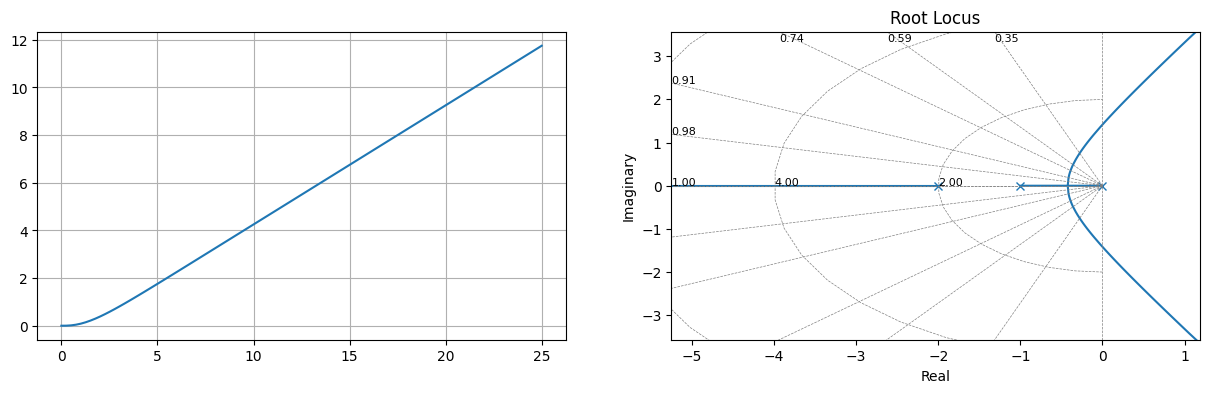

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

In [5]:
Ts = 3.00
UP = 0.20

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [6]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.4559498107691261

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [7]:
Wn = 4/(zeta*Ts)
Wn

2.9242984684743676

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [8]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s5 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 3) for val in [s1, s2]]
p

[(-1.333+2.603j), (-1.333-2.603j)]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [9]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-3.0, -2.0, 0],
[ 1.0,    0, 0],
[   0,  1.0, 0]])

Matrix([
[1.0],
[  0],
[  0]])

Matrix([[0, 0, 1.0]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [10]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[0,  1.0,    0],
[0,    0,  1.0],
[0, -2.0, -3.0]])

Matrix([
[  0],
[  0],
[1.0]])

Matrix([[1.0, 0, 0]])

Matrix([[0]])

In [11]:
A_aa = np.array([A[0, 0]])
A_ab = np.array([A[0, 1:]])
A_ba = np.array(A[1:, 0])
A_bb = np.array(A[1:, 1:])

B_a = np.array([B[0, 0]])
B_b = np.array(B[1:, 0])

display(sp.Matrix(A_aa))
display(sp.Matrix(A_ab))
display(sp.Matrix(A_ba))
display(sp.Matrix(A_bb))
display(sp.Matrix(B_a))
display(sp.Matrix(B_b))

Matrix([[0]])

Matrix([[1.0, 0]])

Matrix([
[0],
[0]])

Matrix([
[   0,  1.0],
[-2.0, -3.0]])

Matrix([[0]])

Matrix([
[  0],
[1.0]])

In [12]:
n = sp.shape(A_bb)[0]
n

2

# CONTROLADOR

In [13]:
K = ctl.acker(A, B, p)
#K = ctl.place(A, B, p)

sp.Matrix(K)

Matrix([[8.552498, 2.666, 1.0]])

In [14]:
L = ctl.acker(A_bb.T, A_ab.T, p).T
#L = ctl.place(A_bb.T, A_ab.T, p).T

L = sp.Matrix(L)
L

Matrix([
[  -0.334],
[7.554498]])

In [15]:
s = sp.symbols('s')
I = sp.eye(n) 

A_aa, A_ab, A_ba, A_bb = sp.Matrix(A_aa), sp.Matrix(A_ab), sp.Matrix(A_ba), sp.Matrix(A_bb)
B_a, B_b = sp.Matrix(B_a), sp.Matrix(B_b)

A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

### CONSTANTES

As constantes do vetor de ganhos K são:

- $\boldsymbol{K_a} = \boldsymbol{K}[1]$
- $\boldsymbol{K_b} = \boldsymbol{K}[2:]$

As constantes das matrizes chapéu são:

- $\boldsymbol{\hat{A}} = \boldsymbol{Abb} - \boldsymbol{L}\,\boldsymbol{Aab}$
- $\boldsymbol{\hat{B}} = \boldsymbol{\hat{A}}\,\boldsymbol{L}+\boldsymbol{Aba}-\boldsymbol{L}\,\boldsymbol{Aaa}$
- $\boldsymbol{\hat{F}} = \boldsymbol{Bb} - \boldsymbol{L}\,\boldsymbol{Ba}$

As constantes das matrizes til são:

- $\boldsymbol{\tilde{A}} = \boldsymbol{\hat{A}} - \boldsymbol{\hat{F}}\,\boldsymbol{Kb}$
- $\boldsymbol{\tilde{B}} = \boldsymbol{\hat{B}} - \boldsymbol{\hat{F}}\,\boldsymbol{Ka}$
- $\boldsymbol{\tilde{C}} = \boldsymbol{-Kb}$
- $\boldsymbol{\tilde{D}} = -(\boldsymbol{Ka}+\boldsymbol{Kb}\,\boldsymbol{L})$

In [16]:
Ka = sp.Matrix([K[0][0]])
Kb = sp.Matrix(np.array([K[0][1:]]))

display(Ka)
display(Kb)

Matrix([[8.552498]])

Matrix([[2.666, 1.0]])

In [17]:
Ahat = A_bb - L*A_ab
Bhat = Ahat*L + A_ba - L*A_aa
Fhat = B_b - L*B_a

display(Ahat)
display(Bhat)
display(Fhat)

Matrix([
[    0.334,  1.0],
[-9.554498, -3.0]])

Matrix([
[     7.442942],
[-19.472291668]])

Matrix([
[  0],
[1.0]])

In [18]:
Atil = Ahat - Fhat*Kb
Btil = Bhat - Fhat*Ka
Ctil = -Kb
Dtil = -(Ka + Kb*L)

display(Atil)
display(Btil)
display(Ctil)
display(Dtil)

Matrix([
[     0.334,  1.0],
[-12.220498, -4.0]])

Matrix([
[     7.442942],
[-28.024789668]])

Matrix([[-2.666, -1.0]])

Matrix([[-15.216552]])

- O controlador é obtido usando $C(s) = -[\boldsymbol{\tilde{C}}\,(s\boldsymbol{I} - \boldsymbol{\tilde{A}})^{-1}\,\boldsymbol{\tilde{B}} + \boldsymbol{\tilde{D}}]$

In [19]:
C = -(Ctil*(s*I - Atil).inv()*Btil + Dtil)
C = C[0].expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(0.1284*s**4 + 0.8727*s**3 + 3.6196*s**2 + 7.1177*s + 8.1479)/(0.0084*s**4 + 0.0619*s**3 + 0.2972*s**2 + 0.6736*s + 1.0)

# RESPOSTA CONTROLADA

In [20]:
s = ctl.TransferFunction.s
C = eval(str(C))
C

TransferFunction(array([0.1284, 0.8727, 3.6196, 7.1177, 8.1479]), array([0.0084, 0.0619, 0.2972, 0.6736, 1.    ]))

In [21]:
G_ma = G*C
G_ma

TransferFunction(array([0.1284, 0.8727, 3.6196, 7.1177, 8.1479]), array([0.0084, 0.0871, 0.4997, 1.689 , 3.6152, 4.3472, 2.    , 0.    ]))

In [22]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([0.1284, 0.8727, 3.6196, 7.1177, 8.1479]), array([8.4000e-03, 8.7100e-02, 4.9970e-01, 1.8174e+00, 4.4879e+00,
       7.9668e+00, 9.1177e+00, 8.1479e+00]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [23]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(-3.32+0j),
 (-1.875+2.753j),
 (-1.875-2.753j),
 (-1.444+2.478j),
 (-1.444-2.478j),
 (-0.206+1.777j),
 (-0.206-1.777j)]

polos:  (-3.32+0j) (-1.875+2.753j) (-1.875-2.753j) (-1.444+2.478j) (-1.444-2.478j) (-0.206+1.777j) (-0.206-1.777j)
zeros:  (-1.835+2.742j) (-1.835-2.742j) (-1.564+1.84j) (-1.564-1.84j)


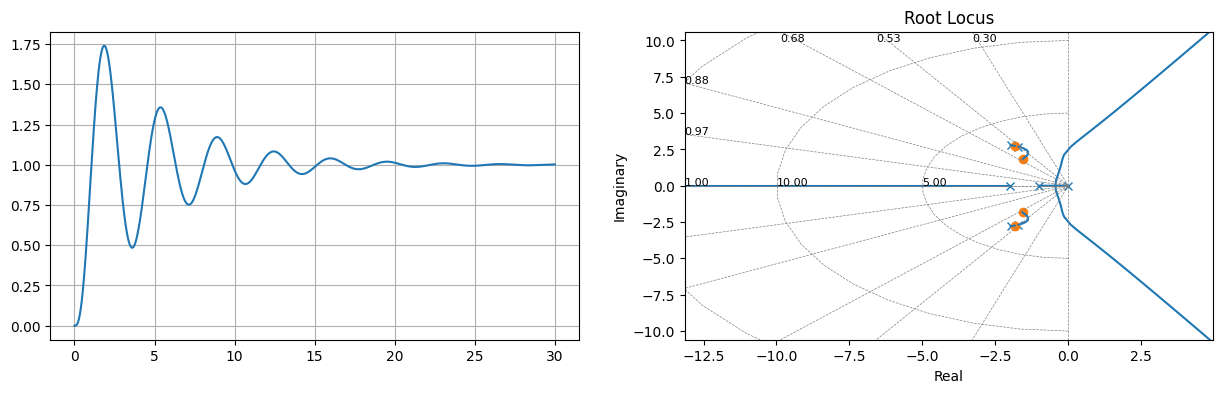

In [24]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G_feedback, T=np.linspace(0, 10*Ts, 1000))
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [25]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.7360773566890184
valor de pico:  1.7397593976711385
tempo de pico:  1.8618618618618619
tempo de assentamento:  18.1981981981982
valor final:  1.002120896841338
erro:  0.0021208968413379825


# APLICANDO VÁRIOS STEPS

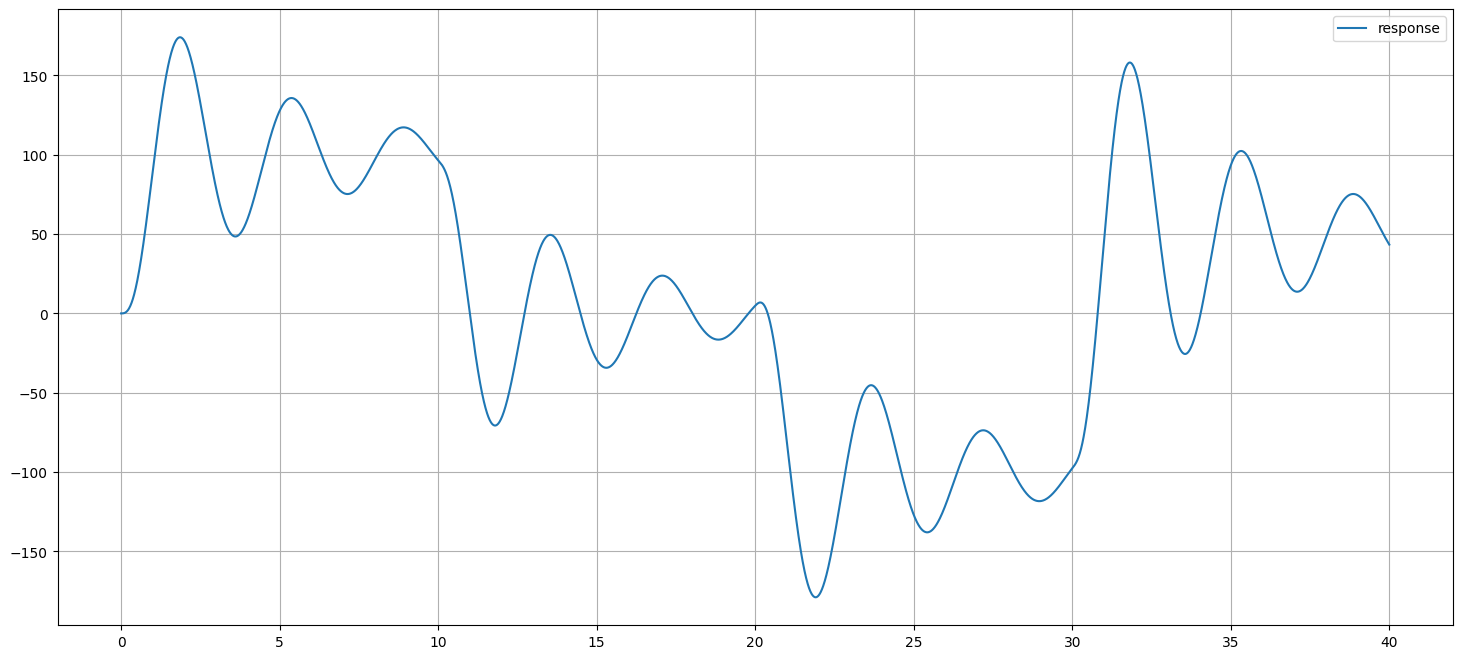

In [ ]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()